**Credit Card Fraud Detection**

In [1]:
#import libraries

import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

In [2]:
#data = pd.read_csv("/kaggle/input/creditcardfraud/creditcard.csv")
#data.head()

in_file = 'creditcard.csv'
data = pd.read_csv(in_file)

**Exploratory Data Analysis**

The only non-transformed variables to work with are:
* Time
* Amount
* Class(1:fraude, 0:not_fraud)

In [3]:
#non-anonymized columns of interest
pd.set_option('precision', 3)
data.loc[:, ['Time', 'Amount']].describe()

,Time,Amount
count,284807.000,284807.000
mean,94813.860,88.350
std,47488.146,250.120
min,0.000,0.000
25%,54201.500,5.600
50%,84692.000,22.000
75%,139320.500,77.165
max,172792.000,25691.160


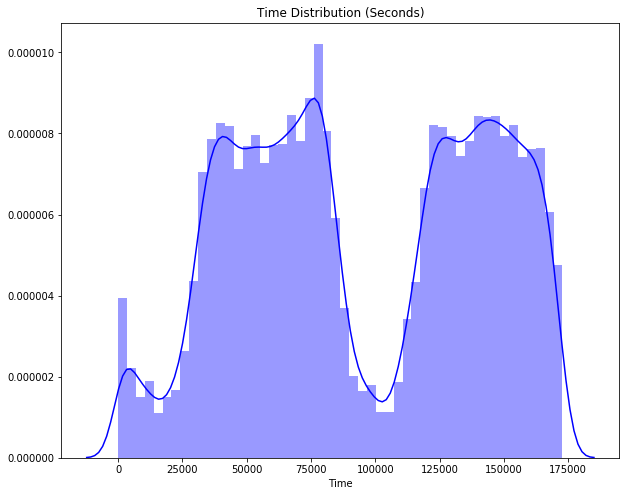

In [4]:
#plot the time feature
plt.figure(figsize=(10,8), )
plt.title('Time Distribution (Seconds)')
sns.distplot(data['Time'],color='blue');

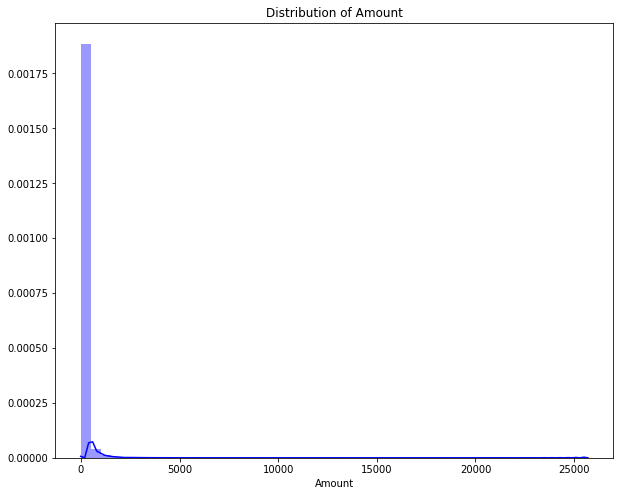

In [5]:
#plot the amount feature
plt.figure(figsize=(10,8))
plt.title('Distribution of Amount')
sns.distplot(data['Amount'],color='blue');

In [6]:
fraud = data['Class'].value_counts()[1]
nonfraud = data['Class'].value_counts()[0]

print(f'Fraudulent:{fraud}, Non-fraudulent:{nonfraud}')
print(f'Ratio of fraud to non-fraud: {fraud}/{nonfraud} ({fraud/nonfraud*100:.3f}%)')

Fraudulent:492, Non-fraudulent:284315
Ratio of fraud to non-fraud: 492/284315 (0.173%)


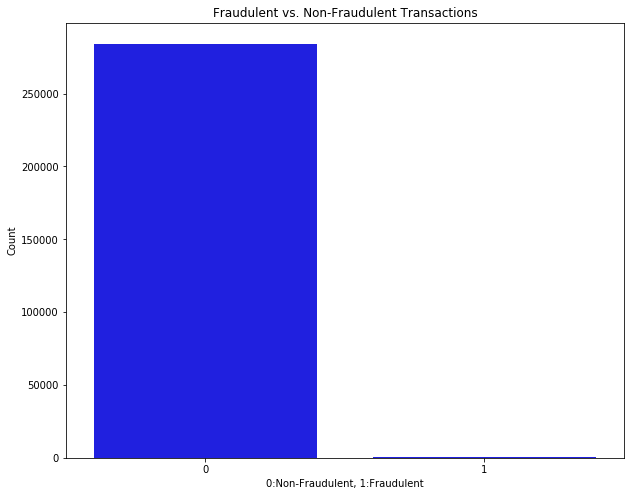

In [7]:
#fraud vs. non-fraud transactions
plt.figure(figsize=(10,8))
sns.barplot(x=data['Class'].value_counts().index,y=data['Class'].value_counts(),color='blue')
plt.title('Fraudulent vs. Non-Fraudulent Transactions')
plt.ylabel('Count')
plt.xlabel('0:Non-Fraudulent, 1:Fraudulent');

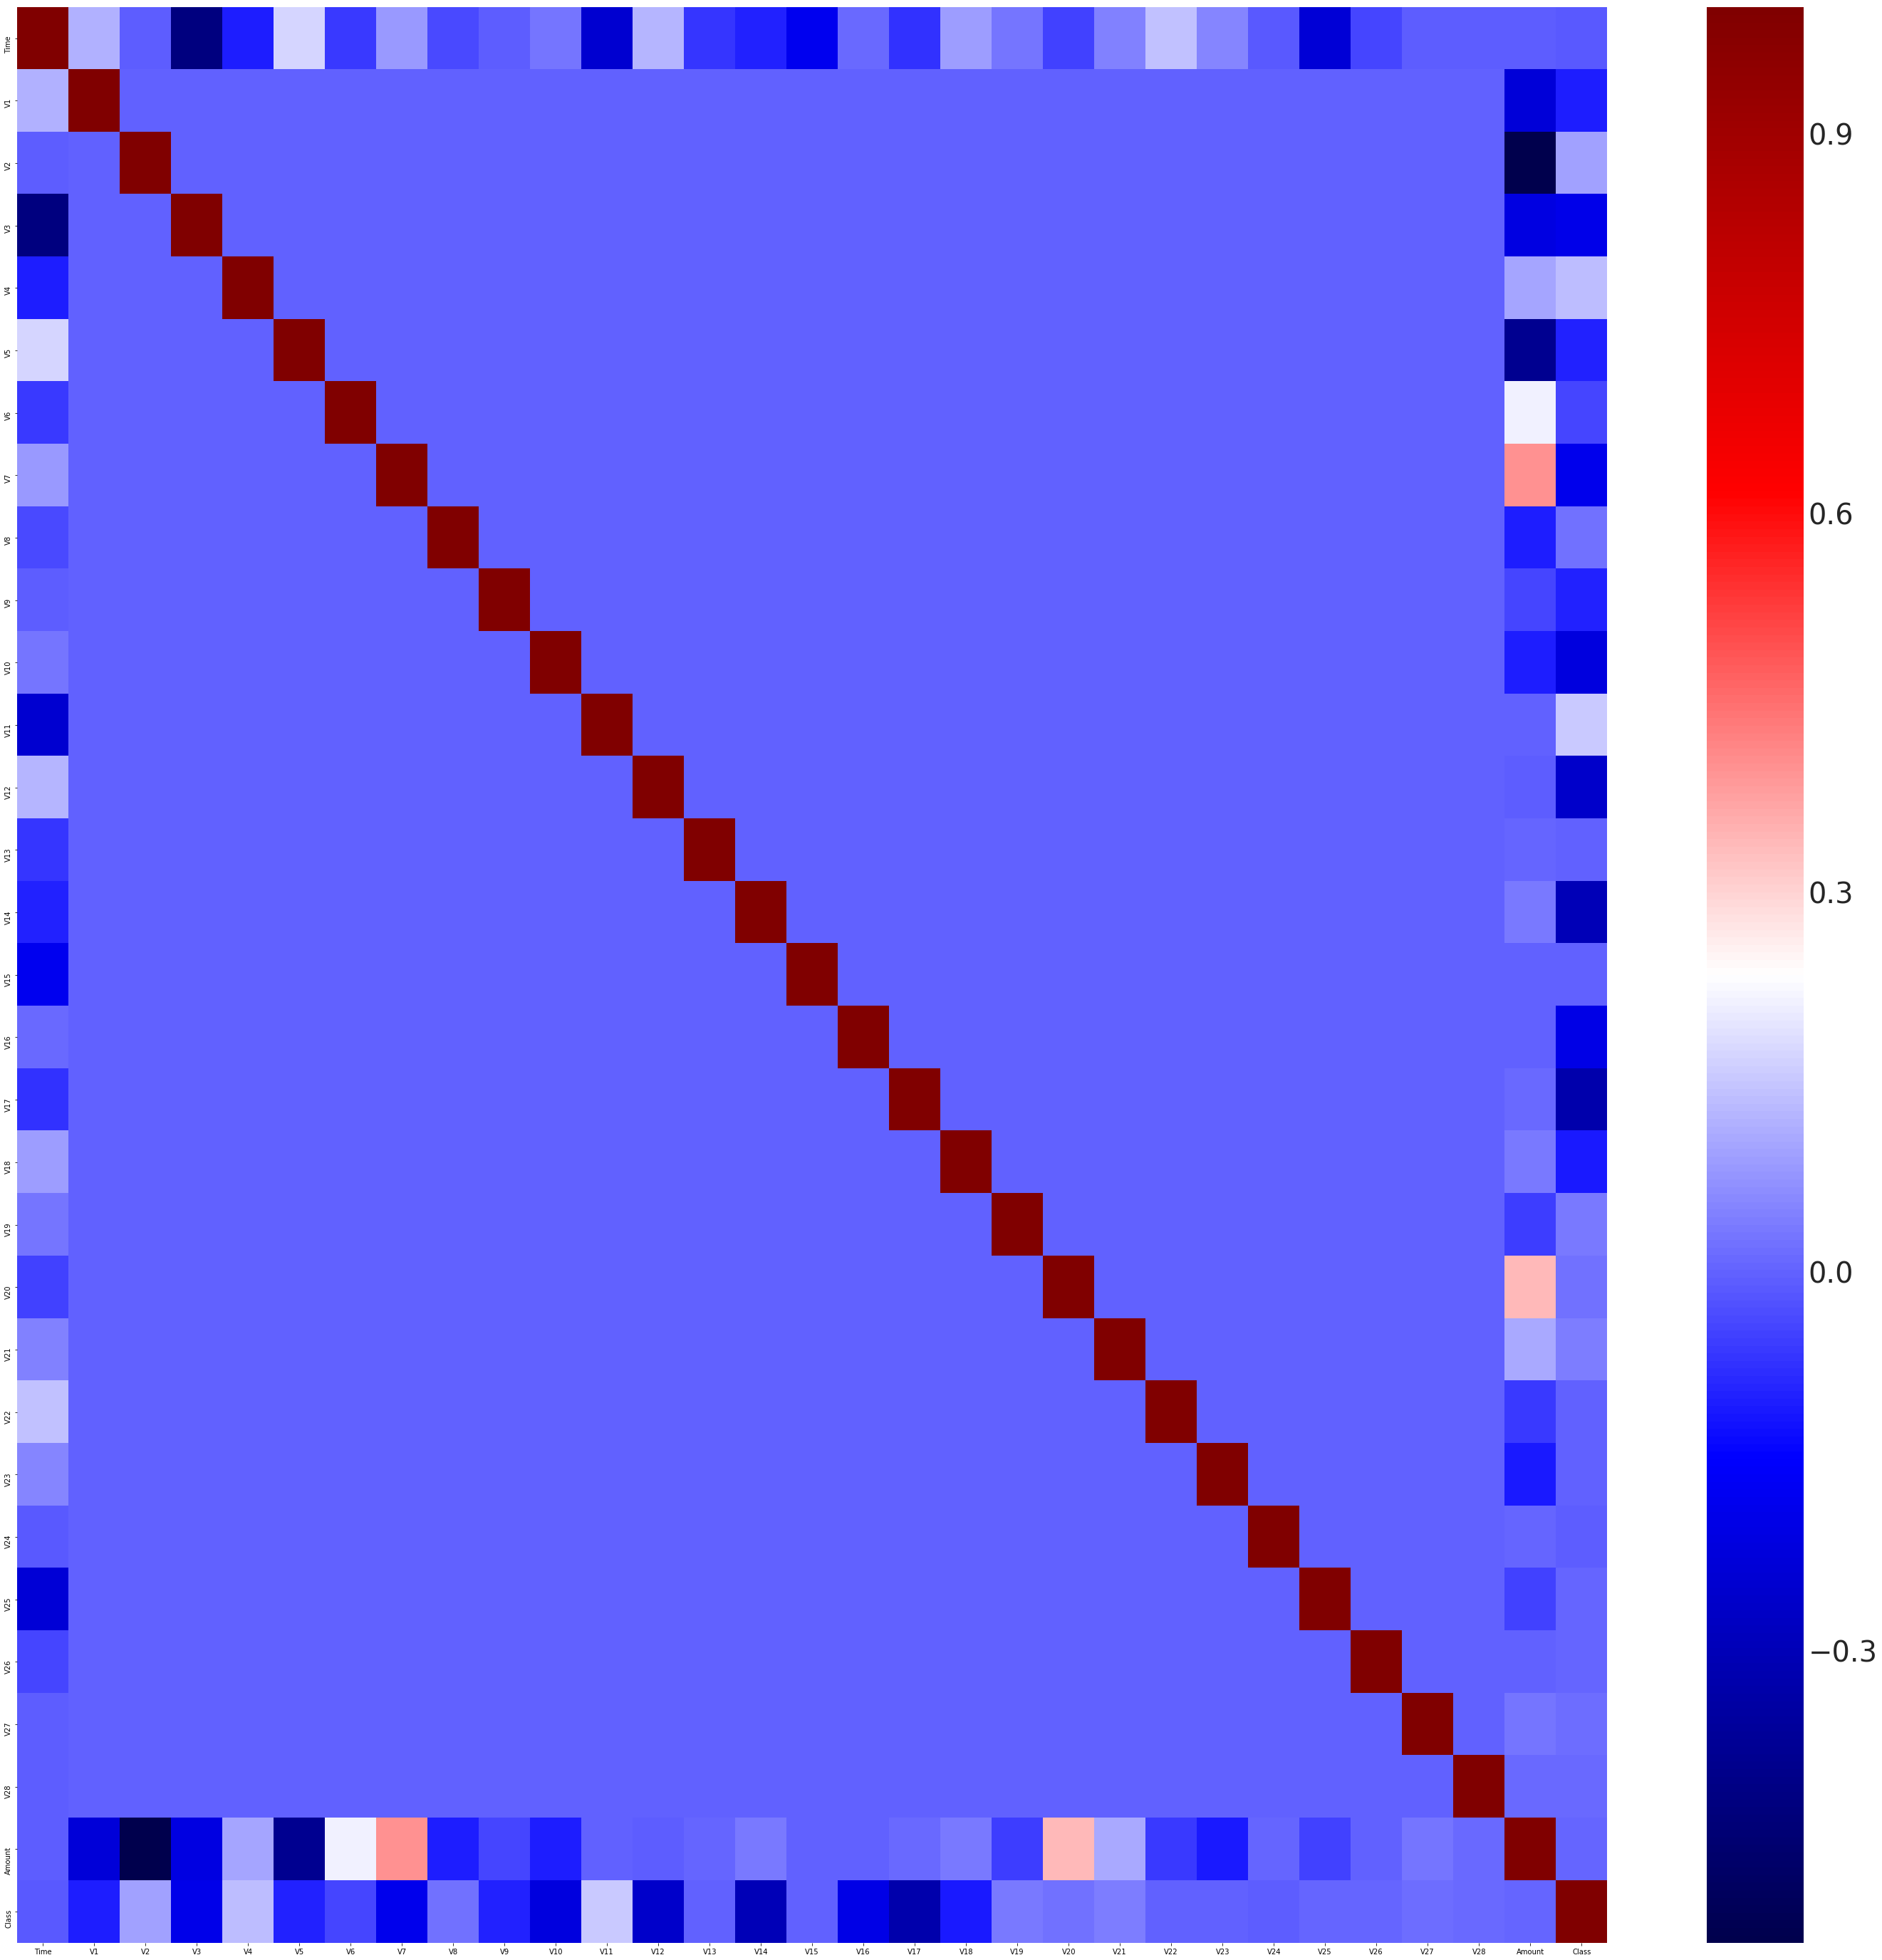

In [8]:
#heatmap to find any high correlations

fig, ax = plt.subplots(figsize=(50,50))
sns.set(font_scale=4)
sns.heatmap(data=data.corr(), cmap="seismic", ax=ax, annot=False)
plt.show();

**Highest correlations come from:**

* Time & V3 (-0.42)
* Amount & V2 (-0.53)
* Amount & V4 (0.4)

There is no risk of multicollinearity, even though the above correlations are high.

**Project Design**

This section will cover the creation of a training data set that will allow the algorithms to pick up the specific characteristics that make a transaction more or less likely to be fraudulent.  I have decided to split my data into 60% train, 20% validation, 20% test before creating any models. 

**StandardScaler on Time and Amount**

* StandardScaler is a common tool when working with classification problems like this. It transforms the data to where there is a mean of 0 and a standard deviation of 1, which means it is standardizing the data into a normal distribution. Standardization is useful for data which has negative values. It arranges the data in normal distribution. It is more useful in classification than regression.
* StandardScaler standardizes a feature by subtracting the mean and then scaling to unit variance. Unit variance means dividing all the values by the standard deviation.

In [9]:
#use StandardScaler on Time and Amount

time_scaler = StandardScaler()
amt_scaler = StandardScaler()

#time
scaled_time = time_scaler.fit_transform(data[['Time']])
time_list = [item for sublist in scaled_time.tolist() for item in sublist]
scaled_time = pd.Series(time_list)

#amount
scaled_amt = amt_scaler.fit_transform(data[['Amount']])
amt_list = [item for sublist in scaled_amt.tolist() for item in sublist]
scaled_amt = pd.Series(amt_list)

In [10]:
#drop original amt and time columns
data.drop(['Amount', 'Time'], axis=1, inplace=True)

In [11]:
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,-1.360,-0.073,2.536,1.378,-0.338,0.462,0.240,0.099,0.364,0.091,...,0.251,-0.018,0.278,-0.110,0.067,0.129,-0.189,0.134,-0.021,0
1,1.192,0.266,0.166,0.448,0.060,-0.082,-0.079,0.085,-0.255,-0.167,...,-0.069,-0.226,-0.639,0.101,-0.340,0.167,0.126,-0.009,0.015,0
2,-1.358,-1.340,1.773,0.380,-0.503,1.800,0.791,0.248,-1.515,0.208,...,0.525,0.248,0.772,0.909,-0.689,-0.328,-0.139,-0.055,-0.060,0
3,-0.966,-0.185,1.793,-0.863,-0.010,1.247,0.238,0.377,-1.387,-0.055,...,-0.208,-0.108,0.005,-0.190,-1.176,0.647,-0.222,0.063,0.061,0
4,-1.158,0.878,1.549,0.403,-0.407,0.096,0.593,-0.271,0.818,0.753,...,0.409,-0.009,0.798,-0.137,0.141,-0.206,0.502,0.219,0.215,0


In [12]:
#drop the predicted column
data_drop = data.drop(columns=['Class'])
answer = data['Class']

In [13]:
X_break, X_test, y_break, y_test = train_test_split(data, answer, \
                                                    test_size=0.2, stratify=data['Class'],
                                                    random_state=42)

#random_state generates a set kind of deck for each random state. 42 will always be the same kind of split
X_train, X_val, y_train, y_val = train_test_split(X_break, y_break, \
                                                    test_size=0.25, stratify=y_break,
                                                    random_state=42)

**Logistic Regression**

Logistic Regression is a statistical model that tries to minimize cost of how wrong a prediction is.

In [14]:
# Run CV with 5 folds

import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV

penalty = ['l2']
C = np.logspace(0, 4, 10, 100, 1000)
param_grid = dict(C=C, penalty=penalty)

logistic = linear_model.LogisticRegression(solver='lbfgs', max_iter=10000)
logistic_grid = GridSearchCV(logistic, param_grid, cv=5, scoring='roc_auc', verbose=10, n_jobs=-1)
logistic_grid.fit(X_train, y_train)


y_pred = logistic_grid.predict(X_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] C=1.0, penalty=l2 ...............................................
[CV] ..................... C=1.0, penalty=l2, score=1.0, total=   1.9s
[CV] C=1.0, penalty=l2 ...............................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV] ..................... C=1.0, penalty=l2, score=1.0, total=   2.2s
[CV] C=1.0, penalty=l2 ...............................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.2s remaining:    0.0s


[CV] ..................... C=1.0, penalty=l2, score=1.0, total=   2.0s
[CV] C=1.0, penalty=l2 ...............................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.3s remaining:    0.0s


[CV] ..................... C=1.0, penalty=l2, score=1.0, total=   2.2s
[CV] C=1.0, penalty=l2 ...............................................


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    8.5s remaining:    0.0s


[CV] ..................... C=1.0, penalty=l2, score=1.0, total=   1.9s
[CV] C=21.5443469003, penalty=l2 .....................................


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.5s remaining:    0.0s


[CV] ........... C=21.5443469003, penalty=l2, score=1.0, total=   2.1s
[CV] C=21.5443469003, penalty=l2 .....................................


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   12.7s remaining:    0.0s


[CV] ........... C=21.5443469003, penalty=l2, score=1.0, total=   2.9s
[CV] C=21.5443469003, penalty=l2 .....................................


[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:   15.6s remaining:    0.0s


[CV] ........... C=21.5443469003, penalty=l2, score=1.0, total=   2.5s
[CV] C=21.5443469003, penalty=l2 .....................................


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   18.2s remaining:    0.0s


[CV] ........... C=21.5443469003, penalty=l2, score=1.0, total=   2.6s
[CV] C=21.5443469003, penalty=l2 .....................................


[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   20.8s remaining:    0.0s


[CV] ........... C=21.5443469003, penalty=l2, score=1.0, total=   2.3s
[CV] C=464.158883361, penalty=l2 .....................................
[CV] ........... C=464.158883361, penalty=l2, score=1.0, total=   2.2s
[CV] C=464.158883361, penalty=l2 .....................................
[CV] ........... C=464.158883361, penalty=l2, score=1.0, total=   2.6s
[CV] C=464.158883361, penalty=l2 .....................................
[CV] ........... C=464.158883361, penalty=l2, score=1.0, total=   2.5s
[CV] C=464.158883361, penalty=l2 .....................................
[CV] ........... C=464.158883361, penalty=l2, score=1.0, total=   2.4s
[CV] C=464.158883361, penalty=l2 .....................................
[CV] ........... C=464.158883361, penalty=l2, score=1.0, total=   2.4s
[CV] C=10000.0, penalty=l2 ...........................................
[CV] ................. C=10000.0, penalty=l2, score=1.0, total=   1.9s
[CV] C=10000.0, penalty=l2 ...........................................
[CV] .

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.4min finished


In [15]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

[[56864     0]
 [    3    95]]
0.99994733331


In [16]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56864
          1       1.00      0.97      0.98        98

avg / total       1.00      1.00      1.00     56962



**Confusion matrix** is a performance measurement for machine learning classification problem where output can be two or more classes. It is a table with 4 different combinations of predicted and actual values.

In [17]:
# Making the Confusion Matrix 
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

In [18]:
cm

array([[56864,     0],
       [    3,    95]])

In [19]:
import matplotlib.pyplot as plt
import itertools

from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

In [20]:
# Plot normalized confusion matrix

plot_confusion_matrix(cm,classes=[0,1])
sns.set(rc={'figure.figsize':(6,6)})
plt.show()

Confusion matrix, without normalization
[[56864     0]
 [    3    95]]


**Decision Tree**

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score,recall_score,f1_score 

classifier = DecisionTreeClassifier(random_state = 0,
                                    criterion = 'gini',  splitter='best', min_samples_leaf=1, min_samples_split=2)
classifier.fit(X_train, y_train)
# Predicting Test Set
y_pred = classifier.predict(X_test)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
results = pd.DataFrame([['Decision tree', acc, prec, rec, f1]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

In [27]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(cm,classes=[0,1])
sns.set(rc={'figure.figsize':(6,6)})
plt.show()

Confusion matrix, without normalization
[[56864     0]
 [    3    95]]


**Random Forest**

In [28]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'max_depth': [5, 10, 15],
    'max_features': ['sqrt'],
    'min_samples_leaf': [10, 20],
    'min_samples_split': [2, 5],
    'n_estimators': [500, 700]
}

rf = RandomForestClassifier()
rf_grid = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc', verbose=10, n_jobs=-1)
rf_grid.fit(X_train,y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=500 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=500, score=1.0, total= 2.8min
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  2.9min remaining:    0.0s


[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=500, score=1.0, total= 2.9min
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  5.8min remaining:    0.0s


[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=500, score=1.0, total= 2.8min
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  8.7min remaining:    0.0s


[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=500, score=1.0, total= 2.9min
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed: 11.6min remaining:    0.0s


[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=500, score=0.9999999999999999, total= 2.6min
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=700 


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 14.3min remaining:    0.0s


[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=700, score=1.0, total= 3.9min
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=700 


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed: 18.3min remaining:    0.0s


[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=700, score=0.9999999999999999, total= 3.9min
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=700 


[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed: 22.3min remaining:    0.0s


[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=700, score=1.0, total= 3.9min
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=700 


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed: 26.2min remaining:    0.0s


[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=700, score=0.9999999999999999, total= 3.9min
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=700 


[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 30.2min remaining:    0.0s


[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=700, score=1.0, total= 4.0min
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=500 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=500, score=1.0, total= 2.9min
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=500 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=500, score=1.0, total= 2.8min
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=500 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=500, score=1.0, total= 2.8min
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=500 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=500, score=1.0, total= 2.8m

KeyboardInterrupt: 

**Artificial Neural Network**


In [29]:
import keras
from keras.models import Sequential
from keras.layers import Dense

# Initialising the ANN
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units =15 , kernel_initializer = 'uniform', activation = 'relu', input_dim = 29))

# Adding the second hidden layer
classifier.add(Dense(units = 15, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Fitting the ANN to the Training set
classifier.fit(X_train.values, y_train.values, batch_size = 32, epochs = 100)

Using TensorFlow backend.


Epoch 1/100
170883/170883 [==============================] - 7s 39us/step - loss: 0.0159 - acc: 0.9986
Epoch 2/100
170883/170883 [==============================] - 7s 38us/step - loss: 0.0012 - acc: 0.9996
Epoch 3/100
170883/170883 [==============================] - 7s 39us/step - loss: 7.5757e-04 - acc: 0.9998
Epoch 4/100
170883/170883 [==============================] - 6s 38us/step - loss: 7.1462e-04 - acc: 0.9999
Epoch 5/100
170883/170883 [==============================] - 7s 39us/step - loss: 7.1595e-04 - acc: 0.9999
Epoch 6/100
170883/170883 [==============================] - 7s 39us/step - loss: 4.9935e-04 - acc: 0.9999
Epoch 7/100
170883/170883 [==============================] - 7s 39us/step - loss: 3.2109e-04 - acc: 0.9999
Epoch 8/100
170883/170883 [==============================] - 7s 38us/step - loss: 2.7717e-04 - acc: 0.9999
Epoch 9/100
170883/170883 [==============================] - 7s 40us/step - loss: 1.6884e-04 - acc: 0.9999
Epoch 10/100
170883/170883 [=================

In [30]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56864
          1       1.00      1.00      1.00        98

avg / total       1.00      1.00      1.00     56962



**Isolation Forest**

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import savefig
from sklearn.ensemble import IsolationForest
# Generating data

rng = np.random.RandomState(42)

# Generating training data 
X_train = 0.2 * rng.randn(1000, 2)
X_train = np.r_[X_train + 3, X_train]
X_train = pd.DataFrame(X_train, columns = ['x1', 'x2'])

# Generating new, 'normal' observation
X_test = 0.2 * rng.randn(200, 2)
X_test = np.r_[X_test + 3, X_test]
X_test = pd.DataFrame(X_test, columns = ['x1', 'x2'])

# Generating outliers
X_outliers = rng.uniform(low=-1, high=5, size=(50, 2))
X_outliers = pd.DataFrame(X_outliers, columns = ['x1', 'x2'])

In [32]:
# training the model
clf = IsolationForest(max_samples=100, random_state=rng)
clf.fit(X_train)

# predictions
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)

In [33]:
# new, 'normal' observations 
print("Accuracy:", list(y_pred_test).count(1)/y_pred_test.shape[0])

# outliers 
print("Accuracy:", list(y_pred_outliers).count(-1)/y_pred_outliers.shape[0])

Accuracy: 0.93
Accuracy: 0.96


**Conclusion**


Credit card fraud has become more and more rampant in recent years. To improve merchants risk management level in an automatic and effective way, building an accurate and easy handling credit card risk monitoring system is one of the key tasks for the merchant banks.

Several algorithms have been implemented on same data set to detect the credit cards frauds. All the algorithms have been analyzed and compared on basis of accuracy on basis of predicting normal cases and outliers or frauds.I implemented different type of algorithms which include neural network from deep learning, anomaly detection algorithms like Isolation Forest,  supervised algorithm like Decision Tree, Artificial Neural Networks, Logistic Regression and Random Forest. This was done to get the best approach for the purpose.

At a threshold of 0.421, the Random Forest model has similar results to the Logistic Regression model. The Random Forest model captures 88/98 fraudulent transactions, but it indicates 9 more normal transactions as fraudulent in comparison to Logistic Regression. Both models are still promising and give good results in the end.

 In case of time taken neural networks and isolation forest algorithms are very impressive. In future this type of algorithm can be used in different cases. For better performance we can change the layers properties neural networks for better results.
